In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from glob import glob
import os
import re
import pyemma.msm as msm
import numpy as np

/Users/robertarbon/miniconda3/envs/science/lib/python3.7/site-packages/pyemma/util/log.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)


# Load the data

Below is the parameters cell for papermill parameterisation:

In [2]:
traj_num = 8
root_dir = 'msm_10ps'

In [3]:
# Parameters
traj_num = 7


The paths to the relevant objects

In [4]:
data_dir = root_dir+'/output_{}'.format(traj_num)
msm_paths = [os.path.join(data_dir, '{}_msm_obj.pyemma'.format(i)) for i in range(1000)]
hmm_paths = glob(os.path.join(data_dir, '*_hmm_obj.pyemma'))


### HMMs

This loads the HMM objects. 

In [5]:
hmms = [msm.MaximumLikelihoodHMSM().load(x) for x in hmm_paths]

/Users/robertarbon/miniconda3/envs/science/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


This determins which 'chunk' of the trajectory each HMM object pertains to. 

In [6]:
hmm_chunks = [int(re.search('^[0-9]+', os.path.basename(x)).group(0)) for x in hmm_paths]
hmm_chunks[:10]

[32, 127, 132, 687, 557, 56, 143, 156, 264, 271]

Now make a dictionary out of them. 

In [7]:
hmms_dict = dict(zip(hmm_chunks, hmms))

### MSMs


Now load the MSMs. There's one for every chunk so we don't need to label them. 

In [8]:
msms = [msm.MaximumLikelihoodMSM().load(x) for x in msm_paths]

This is the conversion between lag in frames (which the MSM object keeps) and the time in ps. 

In [9]:
lag = msms[0].lagtime
dt = np.round(10/lag, 2)
dt 

0.1

# Image
## Pruning the timescales. 

We only want to keep those chunks for which the timescales and corresponding HMM meet certain criteria. 

1. The HMM can't contain absorbing states. 
2. The MSM timescales are all longer than the MSM lag time (so are not spurious). 

First let's get the timescales from the MSMs.  This is irrespective of whether they have clear separation or not. We'll keep the first three for clarity. 

In [10]:
msm_timescales = np.concatenate([mm.timescales()[np.newaxis, :3] for mm in msms], axis=0)
msm_timescales.shape

(1000, 3)

HMMs were only created if there was a timescale separation of 1.5. Of these we'll keep those that don't have any `1` on the diagonal of the transition marix. This indicates there was an absorbing state which we're ignoring. We'll call this `hmm_no_abs` i.e. hmm no absorbing state. 

In [11]:
hmm_no_abs = {k : v for k, v in hmms_dict.items() if not np.any(np.diag(v.transition_matrix)==1)}

len(hmm_no_abs)

166

Now calculate the numbthis is the number of metastable states

In [12]:
hmm_n_states = {k: v.nstates for k, v in hmm_no_abs.items()}

We only want thos states for which the slow timescales are longer than the msm lag time. 

In [13]:
hmm_non_spurious = {k: v for k, v in hmm_n_states.items() if msm_timescales[k,v-2] >= lag}

len(hmm_non_spurious)

165

This is a list of lists which gives the chunks which have 2 (and 3, and 4) states. 

In [14]:
idx_by_n_states = [[k for k, v in hmm_non_spurious.items() if v>=i] for i in range(2,5)]
idx_by_n_states = [x for x in idx_by_n_states if len(x) > 0]
len(idx_by_n_states)

3

## Slow timescale plots from MSM


In [15]:
time = np.arange(len(msms)) # timescale of trajectory in nanoseconds
print(msm_timescales.shape)
print(time.shape)

(1000, 3)
(1000,)


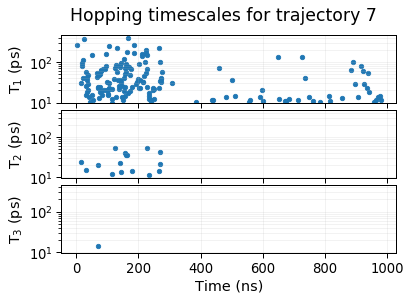

In [16]:
with sns.plotting_context('paper', font_scale=1.5):
    n_rows = len(idx_by_n_states)
    fig, axes = plt.subplots(n_rows,sharex=True, sharey=True,  figsize=(6,4))
    if n_rows==1: axes = [axes]
    # Each row will have those timescales which define the number of states.  
    for i in range(n_rows):
        
        idx = idx_by_n_states[i]
        
        axes[i].scatter(time[idx], msm_timescales.T[i][idx]*dt, marker='o', s=20)
        axes[i].set_yscale('log')
        # Set ylim so that top marker shows up
        ylim = axes[i].get_ylim()
        axes[i].set_ylim(lag*dt-0.1,ylim[1])
        # Labels
        axes[i].set_ylabel(r'T$_{{{}}}$ (ps)'.format(i+1))
        if i == n_rows-1: axes[i].set_xlabel('Time (ns)')
        # set the grid
        axes[i].grid(b=True, which='both', zorder=1, alpha=0.2)

    fig.suptitle('Hopping timescales for trajectory {}'.format(traj_num))
    fig.subplots_adjust(hspace=0.1)
    plt.savefig('traj_{}_hopping_timescales.pdf'.format(traj_num), 
               bbox_inches='tight')